Final Project - Level 2 Assignment

Student: Giovanna Melo Benites

Nossa escolha: PRIO3 . Baixa corr e Retorno maior comparado as outras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Importing data
tickers = ['CVCB3.SA','BRFS3.SA', 'SBSP3.SA', 'MRVE3.SA', 'PRIO3.SA', 'ZN=F']
quotes = pd.DataFrame()
for i in tickers:
    quotes[i] = yf.download(i, start='2019-04-29', end='2024-04-29')['Adj Close']
quotes

# Calculating returns
returns = np.log(quotes / quotes.shift(1))

# Expected returns
expected_return = returns.mean()

# ZN=F shows the US10Y note futures, which will be used as the risk-free rate
risk_free = expected_return['ZN=F']

# Covariance and correlation
cov = returns.cov()
corr = returns.corr()

# Initializing lists to store values
list_returns = []
list_volatility = []
list_weights =[]
list_sharpe_ratio = []


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate and store weights, weighted_returns, volatility and sharpe ratio

num_stocks = len(tickers)
num_portfolios = 10000

for portfolio in range(num_portfolios):
  weight = np.random.random(num_stocks)
  weight /= np.sum(weight)
  list_weights.append(weight)

  portfolio_expected_return = np.dot(weight, expected_return)
  list_returns.append(portfolio_expected_return)

  vol = np.sqrt(np.dot(weight.T, np.dot(cov,weight)))
  list_volatility.append(vol)

  sharpe_ratio = (portfolio_expected_return - risk_free)/vol
  list_sharpe_ratio.append(sharpe_ratio)

In [4]:
# Creating a dictionary to store returns, volatility and sharpe ratios
dic_portfolios = {'Return': list_returns, 'Volatility': list_volatility, 'Sharpe Ratio': list_sharpe_ratio}

# Populating the dictionary with stock weights
for count, stock in enumerate(tickers):
  dic_portfolios[stock + 'Weight'] = [weight[count] for weight in list_weights]

# Creating portfolios dataframe
portfolios = pd.DataFrame(dic_portfolios)
columns = ['Return', 'Volatility', 'Sharpe Ratio'] + [stock + 'Weight' for stock in tickers]
portfolios = portfolios[columns]

In [5]:
# Identify minimum variance portfolio
min_vol = portfolios['Volatility'].min()
min_variance_portfolio = portfolios.loc[portfolios['Volatility'] == min_vol]
min_variance_portfolio.T

,7950
Return,-0.000086
Volatility,0.009398
Sharpe Ratio,0.002105
CVCB3.SAWeight,0.075980
BRFS3.SAWeight,0.047814
SBSP3.SAWeight,0.049803
MRVE3.SAWeight,0.061681
PRIO3.SAWeight,0.094295
ZN=FWeight,0.670426


In [6]:
# Identify max sharpe portfolio
max_sharpe = portfolios['Sharpe Ratio'].max()
max_sharpe_portfolio = portfolios.loc[portfolios['Sharpe Ratio'] == max_sharpe]
max_sharpe_portfolio.T

,5935
Return,0.001026
Volatility,0.022910
Sharpe Ratio,0.049413
CVCB3.SAWeight,0.003778
BRFS3.SAWeight,0.073728
SBSP3.SAWeight,0.157045
MRVE3.SAWeight,0.034056
PRIO3.SAWeight,0.487763
ZN=FWeight,0.243631


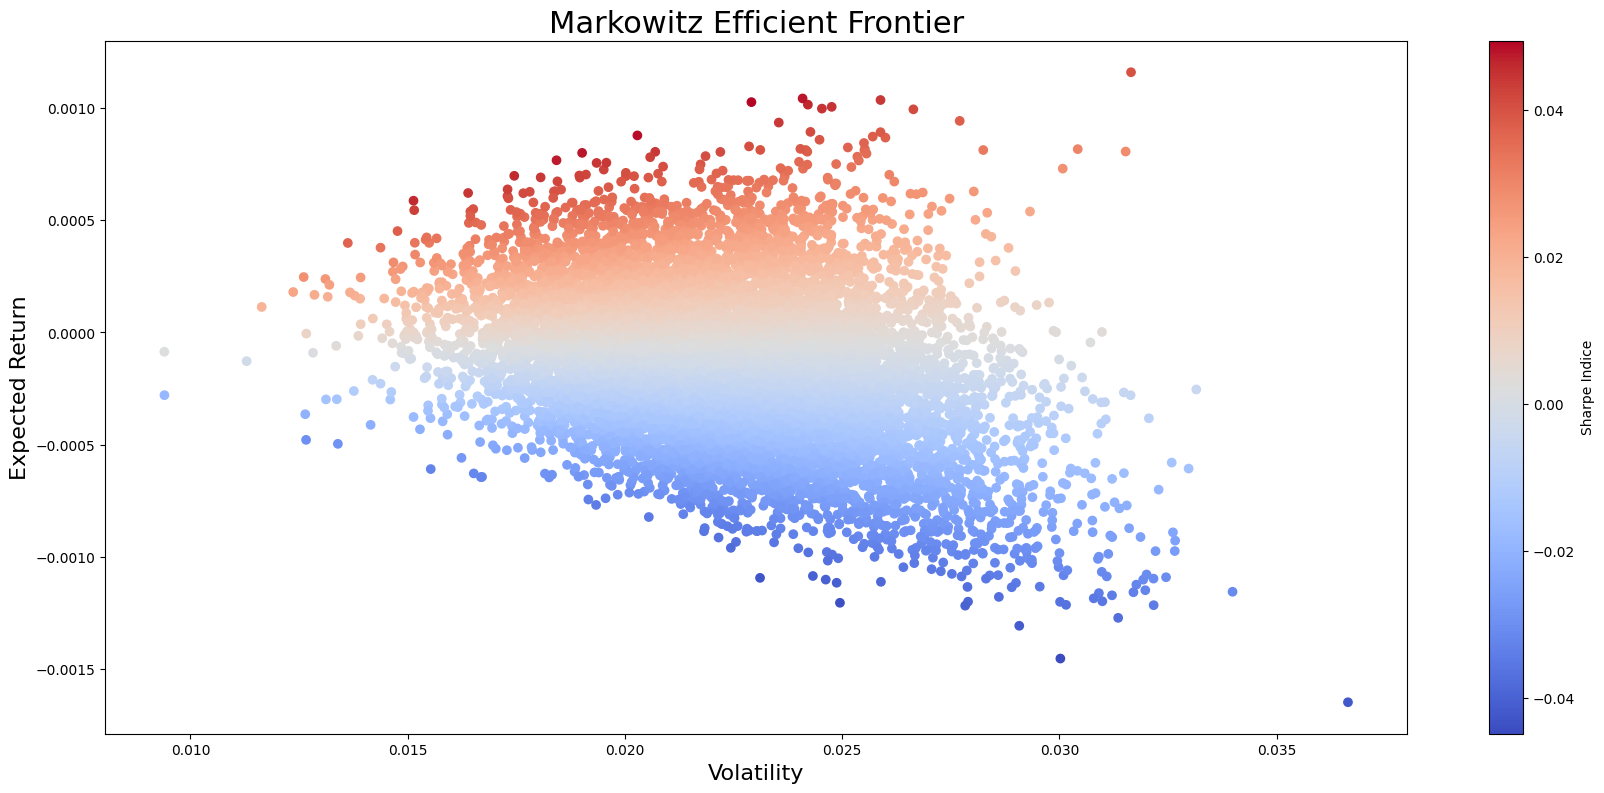

In [7]:
# Plot the Markowitz Efficient Frontier

plt.figure(figsize=(21,9))
plt.scatter(list_volatility, list_returns, c = list_sharpe_ratio, marker ='o',cmap='coolwarm' )
plt.xlabel('Volatility', fontsize=16)
plt.ylabel('Expected Return', fontsize=16)
plt.title('Markowitz Efficient Frontier', fontsize=22)
plt.colorbar(label = 'Sharpe Indice')

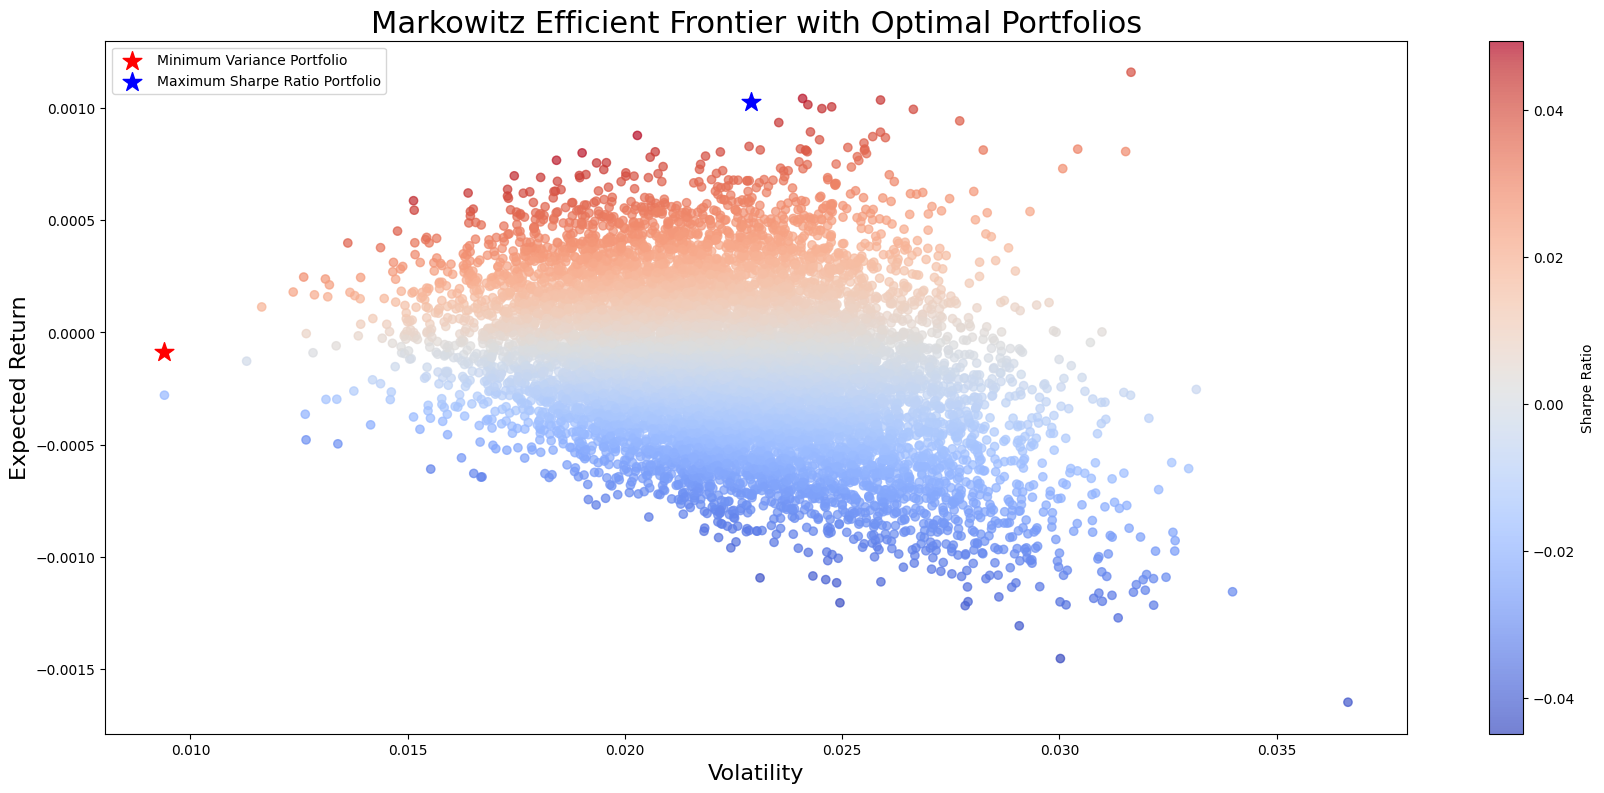

In [8]:
# Plot the Markowitz Efficient Frontier with optimal portfolios
plt.figure(figsize=(21,9))

# Scatter plot of portfolios
plt.scatter(list_volatility, list_returns, c=list_sharpe_ratio, marker='o', cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')

# Highlight minimum variance portfolio
plt.scatter(min_variance_portfolio['Volatility'], min_variance_portfolio['Return'], color='red', marker='*', s=200, label='Minimum Variance Portfolio')

# Highlight maximum Sharpe ratio portfolio
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], color='blue', marker='*', s=200, label='Maximum Sharpe Ratio Portfolio')

plt.xlabel('Volatility', fontsize=16)
plt.ylabel('Expected Return', fontsize=16)
plt.title('Markowitz Efficient Frontier with Optimal Portfolios', fontsize=22)
plt.legend()
plt.show()


In [9]:
# optimization with constraints such as budget constraints (e.g., fully invested portfolio) or minimum/maximum weight constraints.

from scipy.optimize import minimize

# Define the objective function for optimization (negative Sharpe ratio)
def objective_function(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

# Constraints and bounds
def constraints(weights):
    return np.sum(weights) - 1

bounds = [(0, 1) for _ in tickers]
constraints = {'type': 'eq', 'fun': constraints}

# Optimization
initial_weights = num_stocks * [1. / num_stocks,]
result = minimize(objective_function, initial_weights, args=(expected_return, cov, risk_free), method='SLSQP', bounds=bounds, constraints=constraints)

optimized_weights = result.x
optimized_return = np.dot(optimized_weights, expected_return)
optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov, optimized_weights)))

print('Optimized Weights:', optimized_weights)
print('Optimized Return:', optimized_return)
print('Optimized Volatility:', optimized_volatility)


Optimized Weights: [1.32964155e-16 0.00000000e+00 1.62018441e-01 5.57098179e-19
 6.05645222e-01 2.32336337e-01]
Optimized Return: 0.0013326912429007887
Optimized Volatility: 0.02622902812671561


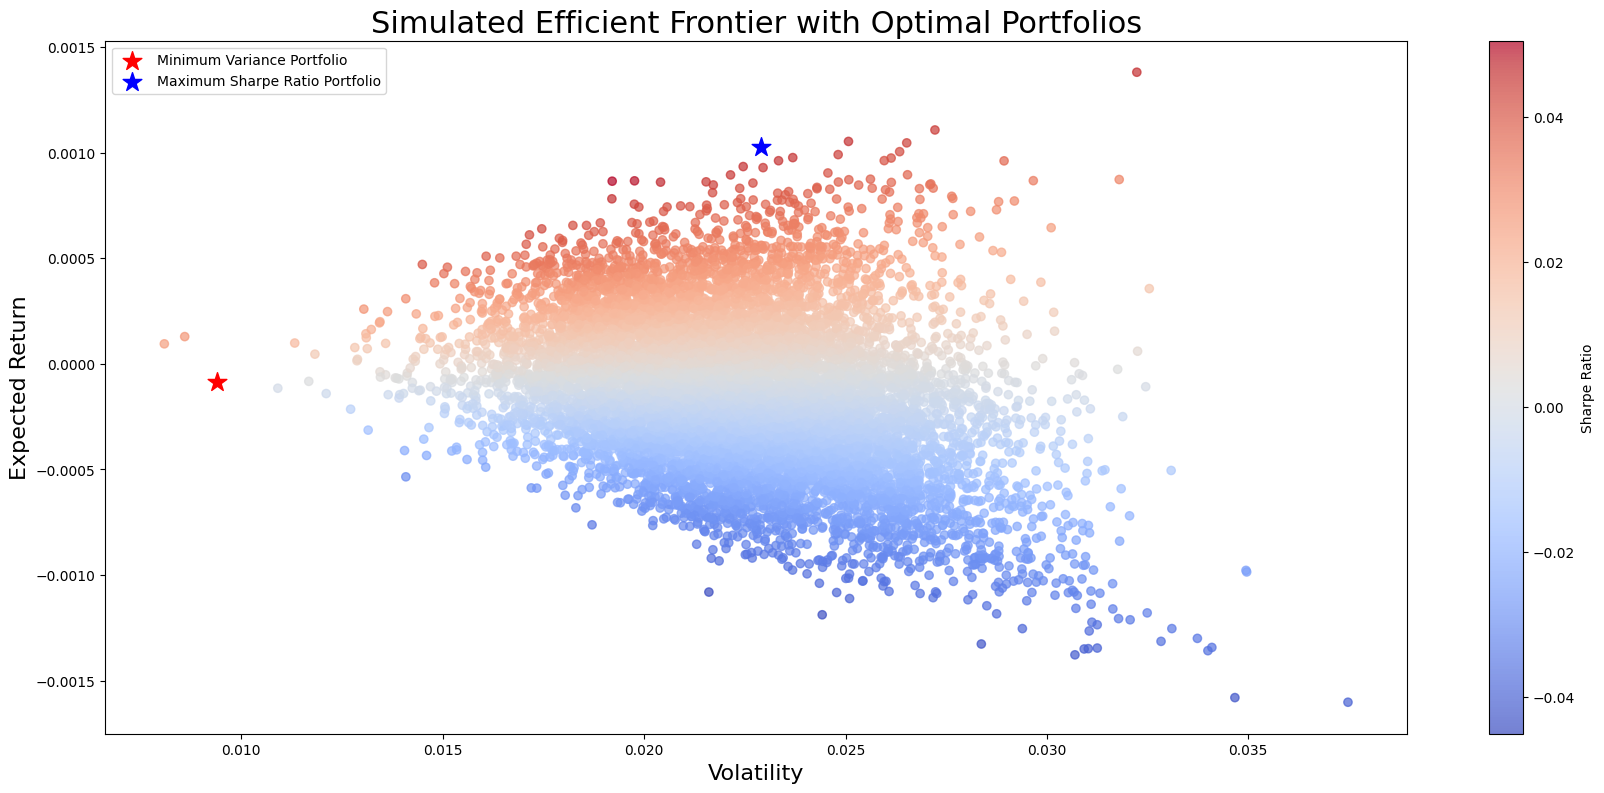

In [11]:
# Monte Carlo simulation for efficient frontier

def simulate_portfolios(num_portfolios, tickers, returns, cov_matrix, risk_free_rate):
    results = {'Returns': [], 'Volatility': [], 'Sharpe Ratio': []}
    for _ in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        portfolio_return = np.dot(weights, returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        results['Returns'].append(portfolio_return)
        results['Volatility'].append(portfolio_volatility)
        results['Sharpe Ratio'].append(sharpe_ratio)
    return pd.DataFrame(results)

# Perform simulation
num_simulations = 10000
simulation_results = simulate_portfolios(num_simulations, tickers, expected_return, cov, risk_free)

# Plot the simulated portfolios
plt.figure(figsize=(21,9))
plt.scatter(simulation_results['Volatility'], simulation_results['Returns'], c=simulation_results['Sharpe Ratio'], marker='o', cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')

# Highlight minimum variance and maximum Sharpe ratio portfolios
plt.scatter(min_variance_portfolio['Volatility'], min_variance_portfolio['Return'], color='red', marker='*', s=200, label='Minimum Variance Portfolio')
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], color='blue', marker='*', s=200, label='Maximum Sharpe Ratio Portfolio')

plt.xlabel('Volatility', fontsize=16)
plt.ylabel('Expected Return', fontsize=16)
plt.title('Simulated Efficient Frontier with Optimal Portfolios', fontsize=22)
plt.legend()
plt.show()
